# ViLT Visual Question Answering Demo
Using the `vilt-b32-finetuned-vqa` model from HuggingFace Transformers

## 1. Setup and Imports

In [1]:
!pip install transformers requests pillow

In [2]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image
import matplotlib.pyplot as plt

/home/lab/miniconda3/envs/cancer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-18 15:38:42.860182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-18 15:38:42.925647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-18 15:38:44.110180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 2. Load Model and Processor

In [3]:
# Load processor and model
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

## 3. Prepare Image and Question

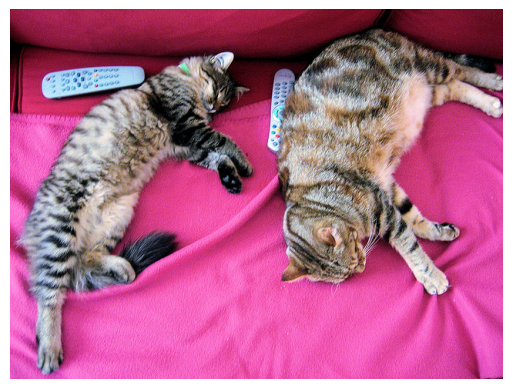

Question: How many cats are there?


In [4]:
# Image URL and question
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
question = "How many cats are there?"

# Download and display image
image = Image.open(requests.get(image_url, stream=True).raw)
plt.imshow(image)
plt.axis('off')
plt.show()

print("Question:", question)

## 4. Process Inputs and Run Model

In [5]:
# Prepare inputs for the model
encoding = processor(image, question, return_tensors="pt")

# Forward pass
outputs = model(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()

# Get predicted answer
answer = model.config.id2label[idx]
print(f"Predicted answer: {answer}")

Predicted answer: 2


## 5. Interactive VQA Function

In [6]:
def ask_question(image_url, question):
    """
    Ask a question about an image
    
    Args:
        image_url (str): URL of the image
        question (str): Question about the image
    """
    # Download image
    try:
        image = Image.open(requests.get(image_url, stream=True).raw)
        
        # Display image
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Q: {question}", pad=20)
        plt.show()
        
        # Process and predict
        encoding = processor(image, question, return_tensors="pt")
        outputs = model(**encoding)
        answer = model.config.id2label[outputs.logits.argmax(-1).item()]
        
        print(f"\nQuestion: {question}")
        print(f"Answer: {answer}")
        
    except Exception as e:
        print(f"Error: {str(e)}")

## 6. Try Different Examples

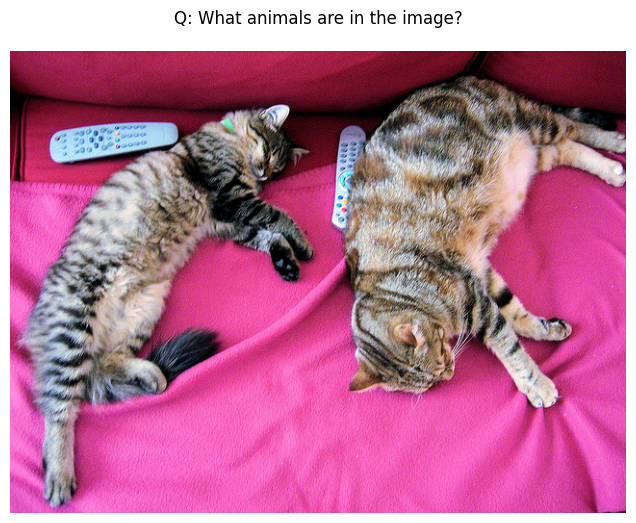


Question: What animals are in the image?
Answer: cats


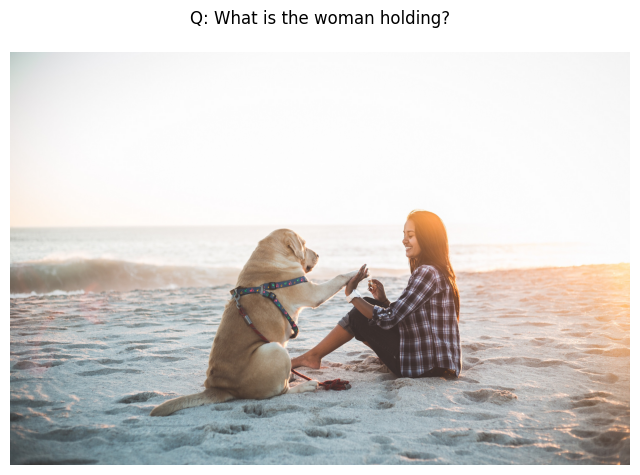


Question: What is the woman holding?
Answer: dog
Error: cannot identify image file <_io.BytesIO object at 0x75c51055ea90>


In [7]:
# Example 1
ask_question(
    image_url="http://images.cocodataset.org/val2017/000000039769.jpg",
    question="What animals are in the image?"
)

# Example 2
ask_question(
    image_url="https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg",
    question="What is the woman holding?"
)

# Example 3 (try your own!)
ask_question(
    image_url="https://upload.wikimedia.org/wikipedia/commons/4/47/New_york_times_square-terabass.jpg",
    question="Is this during the day or night?"
)

## 7. Advanced Usage - Confidence Scores

In [8]:
def get_answer_with_confidence(image_url, question, top_k=3):
    """
    Get answer with confidence scores
    
    Args:
        image_url (str): URL of the image
        question (str): Question about the image
        top_k (int): Number of top answers to show
    """
    try:
        image = Image.open(requests.get(image_url, stream=True).raw)
        encoding = processor(image, question, return_tensors="pt")
        outputs = model(**encoding)
        
        # Get softmax probabilities
        probs = outputs.logits.softmax(dim=1).squeeze()
        
        # Get top k predictions
        top_probs, top_indices = probs.topk(top_k)
        
        print(f"Question: {question}")
        print("Top predictions:")
        for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
            print(f"{i+1}. {model.config.id2label[idx.item()]}: {prob.item():.2%}")
            
    except Exception as e:
        print(f"Error: {str(e)}")

In [9]:
# Example with confidence scores
get_answer_with_confidence(
    image_url="http://images.cocodataset.org/val2017/000000039769.jpg",
    question="What are the animals doing?",
    top_k=5
)

Question: What are the animals doing?
Top predictions:
1. sleeping: 56.34%
2. playing: 15.49%
3. resting: 7.55%
4. laying down: 6.74%
5. laying: 3.41%
